In [1]:
import numpy as np
import os
import glob
import sys
import torch
from pathlib import Path

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
grandparent_dir = os.path.abspath(os.path.join(parent_dir, '..'))
sys.path.append(grandparent_dir)
print(grandparent_dir)

import gendata
import learner as ln
from utils import Logger, read_config_file, set_random_seed, tensors_to_numpy

from learner.metric.dynamics_metric import (
    calculate_dynamics_metrics,
    plot_dynamics_metrics,
)

/home/lbu/project/PINN_DE


In [2]:
from configs.config_plot import *

seed = 0
set_random_seed(seed)

os.makedirs(output_dir, exist_ok=True)  

# Logger
logger = Logger(output_dir)
logger.info("#" * 100)

2023-08-27 15:24:55 INFO ####################################################################################################


# system

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.autograd import Variable

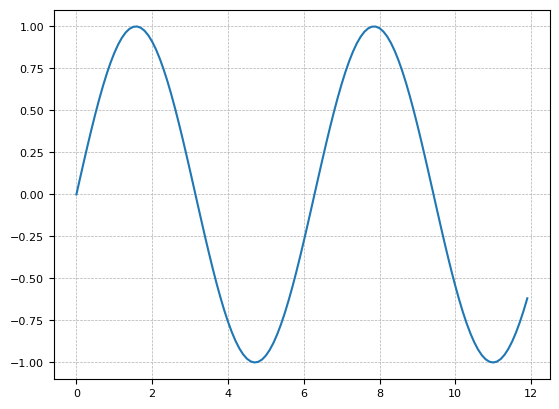

In [4]:
# 构建输入
x = np.arange(0,12,0.1,dtype=np.float32)
y = np.sin(x)
plt.plot(x,y)

In [5]:
# 下面方法用来生成输入的数据集x和y，输入是sin(x)的序列，x为(长度、1、3)长度、batch、维度的一个三维的输入数据，y是对应的后面一个sin(x)的值
def generateData(dataset,timeStep=10):
    dataX,dataY=[],[]
    for i in range(len(dataset)-timeStep):
        a = dataset[i:(i+timeStep)]
        dataX.append(a)
        dataY.append(dataset[i+timeStep])
    return np.array(dataX), np.array(dataY)

data_x,data_y = generateData(y)

train_X = data_x.reshape(1, -1, 10) 
train_y = data_y.reshape(1, -1, 1)

train_X.shape, train_y.shape

((1, 110, 10), (1, 110, 1))

In [6]:
# 构建lstm模型
class myLSTM(torch.nn.Module):
    def __init__(self):
        super(myLSTM,self).__init__()
        # input_size 就是输入数据的维度，这里的是3，因为是3个时间长度，隐藏层个数自己设置，num_layers是lstm的层数。
        self.lstm=torch.nn.LSTM(input_size=10,hidden_size=50,num_layers=2,batch_first=False)
        # 一个全连接，把50变成1
        self.liner1 = torch.nn.Linear(50,1)

    def forward(self,x):
        x,_ = self.lstm(x) # seq batch hidden
        # x[:,-1:,] 这里是取最后一个值，用来进行全连接，下面注释掉的与全连接这句的意思是一样的。
#         out = self.liner1(x[:,-1:,])
        s,b,h = x.shape
        x = x.view(s*b,h)
        x = self.liner1(x)
        out = x.view(s,b,-1)
        return out

# 构建模型，选取下降方法，选取损失函数
myNet = myLSTM() 

In [10]:
lstm_func=torch.nn.LSTM(input_size=10,hidden_size=50,num_layers=10, batch_first=False)
xx = torch.tensor(train_X,dtype=torch.float,requires_grad=True)
out,_  = lstm_func(xx)
out.shape, xx.shape

(torch.Size([1, 110, 50]), torch.Size([1, 110, 10]))

In [8]:
optimizer = torch.optim.Adamax(myNet.parameters(),lr=0.1)
criterion = torch.nn.MSELoss(reduction="mean")

# 进行迭代
for i in range(1000):
    batch_loss = []
    # 把输入和“输出标记y”都变成torch.tensor类型的。每次循环都是对所有的输入进行的训练，暂时没有用到batch。
    xx = torch.tensor(train_X, dtype=torch.float, requires_grad=True)
    yy = torch.tensor(train_y, dtype=torch.float, requires_grad=True)
    prediction = myNet(xx)
    # 计算损失值
    loss = criterion(prediction,yy)
    # 梯度清零
    optimizer.zero_grad()
    # 反向传播
    loss.backward(retain_graph=True)
    # 更新参数
    optimizer.step()
    batch_loss.append(loss.data.numpy())
    if i% 100==0:
        print(i,np.mean(batch_loss))

0 0.554914
100 5.1656432e-05
200 1.6338006e-05
300 8.82548e-06
400 5.6307276e-06
500 3.802097e-06
600 2.647034e-06
700 1.9056765e-06
800 1.4310598e-06
900 1.1254097e-06


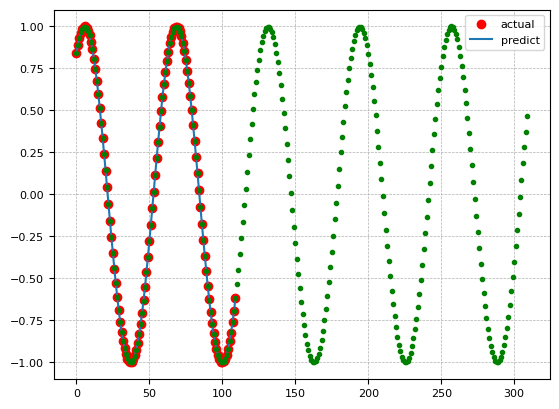

In [9]:
# 查看训练结果
trainx01 = torch.tensor(train_X,dtype=torch.float,requires_grad=True)
trainy01 = myNet(trainx01).data.numpy()
train_t = train_y.reshape(-1,1) # 这个117就是 n,_,_=train_y.shape 中的n
plt.plot(train_t,'o',label='actual',linewidth=10,color='r')
trainy01 = trainy01.reshape(-1,1)
plt.plot(trainy01,label='predict')
plt.legend()

# 下面的3就是上面代码中的时间步长3。这是在循环用后面三个估计第四个，然后第四个加入列表，继续循环，计200次。
storeY = trainy01
for i in range(200):
    stX = storeY[len(storeY)-10:]
    stX = stX.reshape(1,1,10)
    st_train = torch.tensor(stX,dtype=torch.float,requires_grad=True)
    st_y = myNet(st_train).data.numpy()
    st_y = (st_y[0][0])
    storeY = storeY.tolist()
    storeY.append(st_y)
    storeY = np.array(storeY)

plt.plot(storeY,'.',label='predict',color='g')